# **Setup**

## Libraries

We import various libraries for general Python use, DGL (used to create the graph), and PyTorch use

In [1]:
## Warnings output 
import warnings
warnings.filterwarnings('ignore')

## Python Libraries 
import argparse
import os
import sys
from functools import partial
from tqdm import tqdm
import json
from types import SimpleNamespace
import pyrootutils
import hydra
import numpy as np
from sklearn import metrics
import pandas as pd
import scipy.stats as st
from IPython.display import clear_output
import seaborn as sns

## DGL 
import dgl
import dgl.function as fn

## PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import MeanMetric
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import BinaryAUROC, BinaryAveragePrecision

## Config

We simulate having cfg available by loading in hydra config as dict; this is to make potential conversion to modularization easier.

In [2]:
import yaml
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

## User Definition

Primarily for NYU-User development. Each NYU student has their own storage on the NYU HPC cluster. This cell is not necessary if you are not using this cluster. 

In [3]:
try:
    print('Set WD location to', root_path)
except:
    root_path = pyrootutils.find_root(search_from='validation_exp_all.ipynb', indicator=".git")
    pyrootutils.set_root(
        path=root_path,
        project_root_env_var=True,
        dotenv=True,
        pythonpath=True,
        cwd=True
    )
    print('Set WD location to', root_path)


if root_path not in sys.path:
    sys.path.append(root_path)

from src.datamodules.negative_sampler import NegativeSampler
from src.model.SAGE import SAGE
from train_graphsage import SAGELightning, DataModule, ScorePredictor

Set WD location to /scratch/alc9635/projects/NYU-Zillow-Capstone-2022-Team-A


# **Modules**

<ins>Cosine Similarity Function</ins>

In [4]:
def cosine_sim(a, b):
    a = F.normalize(a, p=2, dim=-1)
    b = F.normalize(b, p=2, dim=-1)

    try:
        return a @ b.T
    except:
        print('Matrix multiplication failed. Check dimensions.')

# **Code Setup**

## CFG Definition

<ins>Class for storing config.yaml configurations in nested SimpleNamespace object</ins> (in .py modules we use Hydra, but encountered issues using Hydra config management with .ipynb notebooks)

In [5]:
class NestedNamespace(SimpleNamespace):
    def __init__(self, dictionary, **kwargs):
        super().__init__(**kwargs)
        for key, value in dictionary.items():
            if isinstance(value, dict):
                self.__setattr__(key, NestedNamespace(value))
            else:
                self.__setattr__(key, value)

# Define Config
cfg = NestedNamespace(yaml.load(open('conf/config.yaml'), Loader=Loader))

## CUDA

In [6]:
try:
    if not torch.cuda.is_available():
        device = "cpu"
        print('No GPU available, using CPU')
    else:
        device = "cuda"
        print('Using GPU')
except:
    device = "cpu"
    print('No GPU available, using CPU')

Using GPU


# **Code Implementation**

## Select Configurations and Load Graph / Model

<ins>Select one of ["scene", "cosine", "self"] </ins>

In [103]:
reconnection_method = 'scene'

<ins> Select Other Configurations </ins>

In [104]:
# Define Org ('coco' or 'zillow')
org = 'zillow'

<ins> Load datamodule (contains graph) and saved model output from train_graphsage.py </ins>

In [105]:
if org == 'coco':
    pre_connect_threshold = 0.95
    connect_type = f'_images_{str(pre_connect_threshold).split(".")[-1]}' if reconnection_method == 'cosine' else ''
    csv_dataset_root = cfg.graph.mscoco.graph_dir + connect_type
elif org == 'zillow':
    pre_connect_threshold = 0.975
    connect_type = f'_images_{str(pre_connect_threshold).split(".")[-1]}' if reconnection_method == 'cosine' else ''
    csv_dataset_root = cfg.graph.zillow.graph_dir + connect_type

modal_node_ids_file = os.path.join(csv_dataset_root,'modal_node_ids.json')
datamodule = DataModule(
    csv_dataset_root, 
    modal_node_ids_file, 
    keyword_as_src=False, 
    device=device, 
    batch_size=cfg.training.batch_size, 
    force_reload=False
)

model_name = f'saved_model_{org}{connect_type}.pt'
model = torch.load(model_name)
print(f'loaded model from {model_name}')
model.eval()


Done loading data from cached files.
loaded model from saved_model_zillow.pt


SAGE(
  (layers): ModuleList(
    (0): SAGEConv(
      (feat_drop): Dropout(p=0.7, inplace=False)
      (fc_self): Linear(in_features=512, out_features=512, bias=False)
      (fc_neigh): Linear(in_features=512, out_features=512, bias=False)
    )
    (1): SAGEConv(
      (feat_drop): Dropout(p=0.7, inplace=False)
      (fc_self): Linear(in_features=512, out_features=512, bias=False)
      (fc_neigh): Linear(in_features=512, out_features=512, bias=False)
    )
  )
)

## Reconnecting Train and Val Subgraphs

### Graph Generation

<ins>Initialize Val and Eval Subgraphs and Combine Nodes Only (No Edges)</ins>

In [106]:
val_subgraph = datamodule.g_bid.subgraph(datamodule.val_nid)
eval_subgraph = datamodule.g_bid.subgraph(datamodule.train_nid)

val_img_node_idxs = (val_subgraph.ndata['ntype'] == 0).nonzero().squeeze()
val_img_embeds = val_subgraph.ndata['feat'][val_img_node_idxs]
val_img_node_ids = val_subgraph.ndata['_ID'][val_img_node_idxs]

print('number of val img nodes:', len(val_img_node_ids))
print('number of train img nodes:', len(eval_subgraph.nodes()))

val_nodes_data = {'train_mask': torch.zeros(len(val_img_node_ids), dtype=torch.uint8).to(device),
                  'val_mask': torch.ones(len(val_img_node_ids), dtype=torch.uint8).to(device),
                  'test_mask': torch.zeros(len(val_img_node_ids), dtype=torch.uint8).to(device),
                  'ntype': torch.zeros(len(val_img_node_ids), dtype=torch.int64).to(device),
                  'feat': val_img_embeds.to(device),
                  '_ID': val_img_node_ids}

eval_subgraph.add_nodes(num=len(val_img_node_ids), data=val_nodes_data)

number of val img nodes: 12201
number of train img nodes: 59531


### Identify Node Pairs as Potential Edges

_Here, we run a cell ONLY if it is for the chosen reconnection type_

<ins>Method: Cosine</ins>

In [107]:
if reconnection_method == 'cosine':
    eval_train_img_node_idxs = ((eval_subgraph.ndata['ntype'] == 0)&(eval_subgraph.ndata['train_mask']==1)).nonzero().squeeze()
    eval_train_kw_node_idxs = ((eval_subgraph.ndata['ntype'] == 1)&(eval_subgraph.ndata['train_mask']==1)).nonzero().squeeze()
    eval_val_img_node_idxs = ((eval_subgraph.ndata['ntype'] == 0)&(eval_subgraph.ndata['val_mask']==1)).nonzero().squeeze()
    
    eval_train_img_embeds = eval_subgraph.ndata['feat'][eval_train_img_node_idxs]
    eval_train_kw_embeds = eval_subgraph.ndata['feat'][eval_train_kw_node_idxs]
    eval_val_img_embeds = eval_subgraph.ndata['feat'][eval_val_img_node_idxs]

    cosine_sims_img_matrix = cosine_sim(eval_val_img_embeds, eval_train_img_embeds)
    cosine_sims_img_kw_matrix = cosine_sim(eval_val_img_embeds, eval_train_kw_embeds)

    img_sim_threshold = 0.98
    img_img_k = 5
    img_kw_k = 5
            
    matches = []
    for i in tqdm(range(cosine_sims_img_matrix.size(0)), desc='computing image-image matches'):
        eval_train_img_node_id_matches = eval_train_img_node_idxs[(cosine_sims_img_matrix[i]>img_sim_threshold)]

        if len(eval_train_img_node_id_matches) < img_img_k:
            img_matches, img_match_indices = torch.topk(cosine_sims_img_matrix[i], img_img_k)
            eval_train_img_node_id_matches = eval_train_img_node_idxs[img_match_indices]
        
        kw_matches, kw_match_indices = torch.topk(cosine_sims_img_kw_matrix[i], img_kw_k)
        
        eval_train_kw_node_id_matches = eval_train_kw_node_idxs[kw_match_indices]

        eval_train_node_id_matches = torch.cat((eval_train_img_node_id_matches, eval_train_kw_node_id_matches))
        matches.append(eval_train_node_id_matches.tolist())

    matches_per_img = [len(match_list) for match_list in matches]
    print('match stats:')
    print(f'min matches: {np.min(matches_per_img)}')
    print(f'max matches: {np.max(matches_per_img)}')
    print(f'avg matches: {np.mean(matches_per_img)}')
    print(f'std matches: {np.std(matches_per_img)}')
    print(f'total new edges to add: {sum(matches_per_img)*2}')

<ins>Method: Scene</ins>

In [108]:
if reconnection_method == 'scene':
    eval_train_img_node_idxs = ((eval_subgraph.ndata['ntype'] == 0)&(eval_subgraph.ndata['train_mask']==1)).nonzero().squeeze()
    eval_train_scene_node_idxs = ((eval_subgraph.ndata['ntype'] == 2)&(eval_subgraph.ndata['train_mask']==1)).nonzero().squeeze()

    eval_val_img_node_idxs = ((eval_subgraph.ndata['ntype'] == 0)&(eval_subgraph.ndata['val_mask']==1)).nonzero().squeeze()
    eval_val_scene_node_idxs = ((eval_subgraph.ndata['ntype'] == 2)&(eval_subgraph.ndata['val_mask']==1)).nonzero().squeeze()

    eval_train_img_ids = eval_subgraph.ndata['_ID'][eval_train_img_node_idxs]
    eval_train_scene_ids = eval_subgraph.ndata['_ID'][eval_train_scene_node_idxs]

    eval_val_img_ids = eval_subgraph.ndata['_ID'][eval_val_img_node_idxs]
    eval_val_scene_ids = eval_subgraph.ndata['_ID'][eval_val_scene_node_idxs]

    def get_scene_edges(node_id, input_graph=datamodule.g_bid, eval_train_scene_ids=eval_train_scene_ids):
        u_node, v_node = input_graph.edges()
        u_node_edge_idxs = torch.nonzero(node_id == u_node)
        v_ids = v_node[u_node_edge_idxs]

        v_node_edge_idxs = torch.nonzero(node_id == v_node)
        u_ids = u_node[v_node_edge_idxs]

        all_edge_ids = torch.cat([u_ids, v_ids], dim=0)
        indices = torch.zeros_like(all_edge_ids, dtype = torch.uint8, device = device)

        for elem in eval_train_scene_ids:
            indices = indices | (all_edge_ids == elem)  

        intersection = all_edge_ids[indices] 

        return torch.unique(intersection)

_NOTE: Self loop reconnection type does not require this work_

### Collect Edges for Eval Subgraph

_Here, we run a cell ONLY if it is for the chosen reconnection type_

<ins>Method: Cosine</ins>

In [109]:
if reconnection_method == 'cosine':
    u = []
    v = []

    for i in range(len(matches)):
        val_img_node = eval_val_img_node_idxs[i].item()
        train_matches = matches[i]
        for node_id in train_matches:
            train_img_node = node_id

            u += [val_img_node, train_img_node]
            v += [train_img_node, val_img_node]

<ins>Method: Scene</ins>

In [110]:
if reconnection_method == 'scene':
    u = []
    v = []

    for eval_val_img_id in tqdm(eval_val_img_ids):
        matching_eval_train_scenes = get_scene_edges(eval_val_img_id, 
                                                    input_graph=datamodule.g_bid, 
                                                    eval_train_scene_ids=eval_train_scene_ids)
        
        if matching_eval_train_scenes.size(dim=0) > 0:
            for scene in matching_eval_train_scenes:
                u += [eval_val_img_id.item(), scene.item()]
                v += [scene.item(), eval_val_img_id.item()]

    old_new_eval_node_id_mapper = dict(zip(eval_subgraph.ndata['_ID'].detach().cpu().tolist(), eval_subgraph.nodes().detach().cpu().tolist()))
    u = [old_new_eval_node_id_mapper[old_u] for old_u in u]
    v = [old_new_eval_node_id_mapper[old_v] for old_v in v]

100%|██████████| 12201/12201 [00:11<00:00, 1030.70it/s]


_Again, this is not required for the self loop method_

### Add Edges to Eval Subgraph

_Cosine and Scene methods only_

In [111]:
if reconnection_method == 'cosine' or reconnection_method == 'scene':
    edge_data = {'_ID': torch.arange(torch.max(eval_subgraph.edata['_ID'])+1, torch.max(eval_subgraph.edata['_ID'])+1+len(u), dtype=torch.int64).to(device)}
    eval_subgraph.add_edges(torch.LongTensor(u).to(device), torch.LongTensor(v).to(device), data=edge_data)

eval_subgraph = eval_subgraph.add_self_loop()

### Convert DGL Graph into GraphSAGE Compatible Object

In [112]:
u_eval, v_eval = eval_subgraph.edges()
eval_subgraph_eids = eval_subgraph.edge_ids(u_eval, v_eval)
layer_sampler = dgl.dataloading.NeighborSampler(fanouts=[3]) # During message passing between GNN layers, each node accept messages from a maximum of 25 incoming nodes
batch_size = len(eval_subgraph.edges()[0])

def eval_dataloader(g, layer_sampler, batch_size, eids):
    edge_sampler = dgl.dataloading.as_edge_prediction_sampler(layer_sampler)

    return dgl.dataloading.DataLoader(
        g,
        eids,
        edge_sampler,
        device=device,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
        # num_workers=self.num_workers,
    )

eval_dl = eval_dataloader(eval_subgraph, layer_sampler, batch_size, eval_subgraph_eids)

### Run GraphSAGE Inferences

In [113]:
# Step 6: Run graphSAGE forward inference over entire val_subgraph message flow graph (MFG)

for batch in eval_dl:
    inputs, edge_subgraph, blocks = batch
    
x = blocks[0].srcdata["feat"]
model = model.to(device)
logits = model.forward(blocks, x)

eval_subgraph.ndata['feat_pred_norm'] = F.normalize(logits, p=2, dim=-1)

### Extract Validation Image Features and Keyword Features

In [114]:
# Step 7: Extract validation image features and keyword features for 
eval_val_img_node_ids = ((eval_subgraph.ndata['val_mask']==1)&(eval_subgraph.ndata['ntype']==0)).nonzero().squeeze()
eval_keyword_node_ids = ((eval_subgraph.ndata['ntype']==1)).nonzero().squeeze()

# Post-GraphSAGE embeddings
eval_val_img_feat_sage = eval_subgraph.ndata['feat_pred_norm'][eval_val_img_node_ids]
eval_keyword_feat_sage = eval_subgraph.ndata['feat_pred_norm'][eval_keyword_node_ids]

# Original CLIP embeddings before GraphSAGE forward method
eval_subgraph.ndata['feat_norm'] = F.normalize(eval_subgraph.ndata['feat'], p=2, dim=-1)
eval_val_img_feat_clip = eval_subgraph.ndata['feat_norm'][eval_val_img_node_ids]
eval_keyword_feat_clip = eval_subgraph.ndata['feat_norm'][eval_keyword_node_ids]

### Compute Cosine Similarities

In [115]:
verbose = False

val_sage_link_scores = metrics.pairwise.cosine_similarity(eval_keyword_feat_sage.cpu().detach().numpy(),
                                                          eval_val_img_feat_sage.cpu().detach().numpy())
val_clip_link_scores = metrics.pairwise.cosine_similarity(eval_keyword_feat_clip.cpu().detach().numpy(),
                                                          eval_val_img_feat_clip.cpu().detach().numpy())

if verbose:
    print('means:')
    print('sage:', np.mean(val_sage_link_scores))
    print('clip:', np.mean(val_clip_link_scores))
    print('mins:')
    print('sage:', np.min(val_sage_link_scores))
    print('clip:', np.min(val_clip_link_scores))
    print('maxs:')
    print('sage:', np.max(val_sage_link_scores))
    print('clip:', np.max(val_clip_link_scores))
    print('stds:')
    print('sage:', np.std(val_sage_link_scores))
    print('clip:', np.std(val_clip_link_scores))

### Predict and Compute Precision/Recall/Accuracy

In [116]:
# Adjacency matrix needs to be sub-setted such that rows correspond only... 
# ...to image nodes and columns correspond only to keyword nodes
val_img_indices = (val_subgraph.ndata['ntype']==0).nonzero().cpu().reshape(1, -1)
val_keyword_indices = (val_subgraph.ndata['ntype']==1).nonzero().cpu().reshape(-1, 1)

val_adj_matrix = val_subgraph.adjacency_matrix().to_dense().numpy()
val_adj_matrix = val_adj_matrix[val_keyword_indices, val_img_indices]

method_link_scores = {'sage': val_sage_link_scores, 'clip': val_clip_link_scores}

pred_thresholds = np.linspace(0.1, 0.9, 30)
sage_clip_metrics = pd.DataFrame()
results_dict = {threshold: {} for threshold in pred_thresholds}

for pred_threshold in pred_thresholds:
    results_dict[pred_threshold] = {'sage': {}, 'clip': {}}

    for method in method_link_scores:
        method_link_predictions = (method_link_scores[method] > pred_threshold).astype(int)
        n_keywords = len(method_link_scores[method])
        for metric in ['tp', 'fp', 'fn', 'actual_p', 'precision', 'recall', 'f1']:
            results_dict[pred_threshold][method][metric] = np.empty(n_keywords)
        weights = np.empty(n_keywords)

        for i in range(n_keywords):
            all_p = np.sum(val_adj_matrix[i])
            all_p_pred = np.sum(method_link_predictions[i])
            results_dict[pred_threshold][method]['tp'][i] = np.sum((method_link_predictions[i]==1)&(val_adj_matrix[i]==1))
            results_dict[pred_threshold][method]['fp'][i] = np.sum((method_link_predictions[i]==1)&(val_adj_matrix[i]==0))
            results_dict[pred_threshold][method]['fn'][i] = np.sum((method_link_predictions[i]==0)&(val_adj_matrix[i]==1))
            results_dict[pred_threshold][method]['actual_p'][i] = all_p

            precision = results_dict[pred_threshold][method]['tp'][i] / all_p_pred if all_p_pred > 0 else 0
            recall = results_dict[pred_threshold][method]['tp'][i] / all_p if all_p > 0 else 0

            results_dict[pred_threshold][method]['precision'][i] = precision
            results_dict[pred_threshold][method]['recall'][i] = recall

            weights[i] = all_p
    
    weights /= np.sum(weights)

    for method in results_dict[pred_threshold].keys():
        row = {'threshold': pred_threshold, 'method': method}
        for metric in results_dict[pred_threshold][method]:
            if metric == 'precision' or metric == 'recall':
                row[f'{metric}_micro'] = np.mean(results_dict[pred_threshold][method][metric]*weights)
                row[f'{metric}_macro'] = np.mean(results_dict[pred_threshold][method][metric])

        row['f1_micro'] = 2*(row['precision_micro']*row['recall_micro']) / (row['precision_micro']+row['recall_micro']) if (row['precision_micro']+row['recall_micro']) > 0 else 0
        row['f1_macro'] = 2*(row['precision_macro']*row['recall_macro']) / (row['precision_macro']+row['recall_macro']) if (row['precision_macro']+row['recall_macro']) > 0 else 0
        sage_clip_metrics = pd.concat([sage_clip_metrics, pd.DataFrame([row])], ignore_index=True)

    sage_metrics = sage_clip_metrics[(sage_clip_metrics['method']=='sage')]
    clip_metrics = sage_clip_metrics[(sage_clip_metrics['method']=='clip')]

### Print Summarizing Metrics

In [117]:
print('Best SAGE metrics: ')
print('Precision, Recall at Max Recall:\n', sage_metrics[sage_metrics['recall_macro']==sage_metrics['recall_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])
print('Precision, Recall at Max Precision:\n', sage_metrics[sage_metrics['precision_macro']==sage_metrics['precision_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])

print('Best CLIP metrics: ')
print('Precision, Recall at Max Recall:\n', clip_metrics[clip_metrics['recall_macro']==clip_metrics['recall_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])
print('Precision, Recall at Max Precision:\n', clip_metrics[clip_metrics['precision_macro']==clip_metrics['precision_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])

Best SAGE metrics: 
Precision, Recall at Max Recall:
 threshold          0.100000
precision_macro    0.000422
recall_macro       0.054731
Name: 0, dtype: float64
Precision, Recall at Max Precision:
 threshold          0.900000
precision_macro    0.000450
recall_macro       0.038582
Name: 58, dtype: float64
Best CLIP metrics: 
Precision, Recall at Max Recall:
 threshold          0.100000
precision_macro    0.000438
recall_macro       0.629896
Name: 1, dtype: float64
Precision, Recall at Max Precision:
 threshold          0.403448
precision_macro    0.008179
recall_macro       0.410289
Name: 23, dtype: float64


## Generate Plots

<ins>Micro and Macro Precision and Recall: Plots</ins>

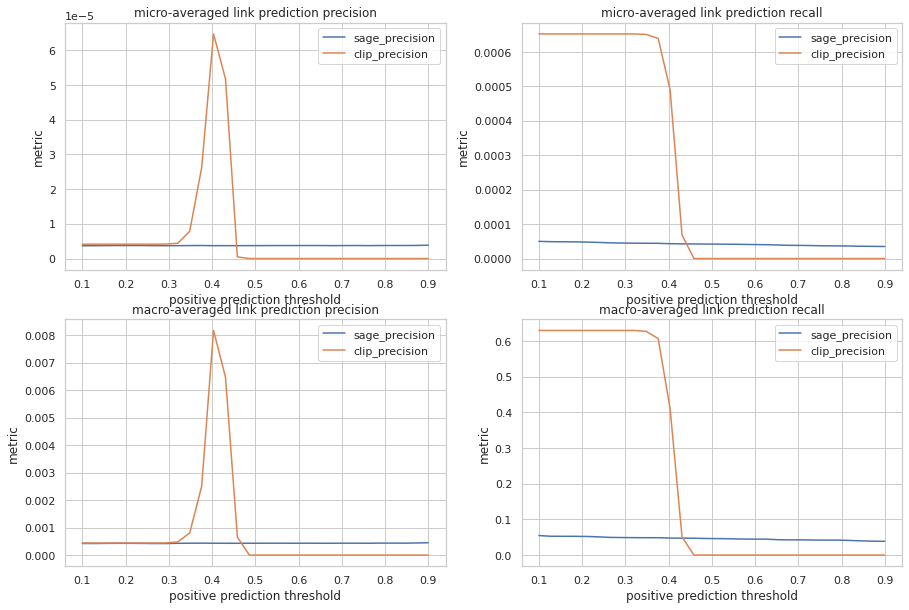

In [118]:
import matplotlib.pyplot as plt

sage_micro_threshold_metrics = sage_clip_metrics[sage_clip_metrics['method']=='sage'][['threshold', 'precision_micro', 'recall_micro']]
clip_micro_threshold_metrics = sage_clip_metrics[sage_clip_metrics['method']=='clip'][['threshold', 'precision_micro', 'recall_micro']]
sage_macro_threshold_metrics = sage_clip_metrics[sage_clip_metrics['method']=='sage'][['threshold', 'precision_macro', 'recall_macro']]
clip_macro_threshold_metrics = sage_clip_metrics[sage_clip_metrics['method']=='clip'][['threshold', 'precision_macro', 'recall_macro']]

fig, axs = plt.subplots(2, 2, figsize=(15,10))
for i, avg_type in enumerate(['micro', 'macro']):
    legend = []
    for j, metric in enumerate(['precision', 'recall']):
        for method in ['sage', 'clip']:
            axs[i,j].plot(sage_clip_metrics[sage_clip_metrics['method']==method]['threshold'], 
                    sage_clip_metrics[sage_clip_metrics['method']==method][f'{metric}_{avg_type}'])
            legend += [f'{method}_{metric}']
        axs[i,j].legend(legend)
        axs[i,j].set_xlabel('positive prediction threshold')
        axs[i,j].set_ylabel('metric')
        axs[i,j].set_title(f'{avg_type}-averaged link prediction {metric}')
plt.show()


<ins>Micro and Macro Precision and Recall: Tabular Data</ins>

In [119]:
macro_metrics = ['recall_macro', 'precision_macro', 'f1_macro']
metrics_dfs = {'sage': sage_metrics, 'clip': clip_metrics}
best_rows = {}
for method in ['sage', 'clip']:
    print(f'Best {method} metrics: ')
    best_rows[method] = {}
    metric_df = metrics_dfs[method]
    metric = 'f1_macro'
    best_rows[method][metric] = metric_df[metric_df[metric]==metric_df[metric].max()][['threshold']+macro_metrics].iloc[0,:]
    print(f'Metrics at best {metric}:\n', best_rows[method][metric])
    print('\n')

Best sage metrics: 
Metrics at best f1_macro:
 threshold          0.900000
recall_macro       0.038582
precision_macro    0.000450
f1_macro           0.000890
Name: 58, dtype: float64


Best clip metrics: 
Metrics at best f1_macro:
 threshold          0.403448
recall_macro       0.410289
precision_macro    0.008179
f1_macro           0.016038
Name: 23, dtype: float64




<ins>Micro and Macro Precision and Recall: Plots by Keyword</ins>

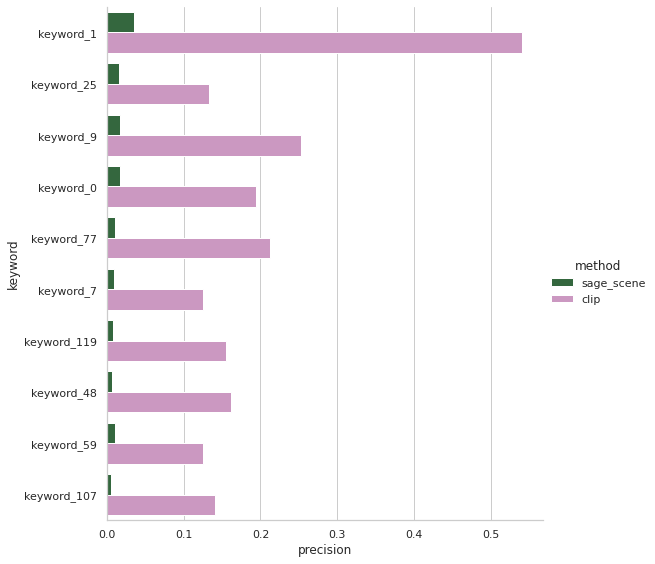

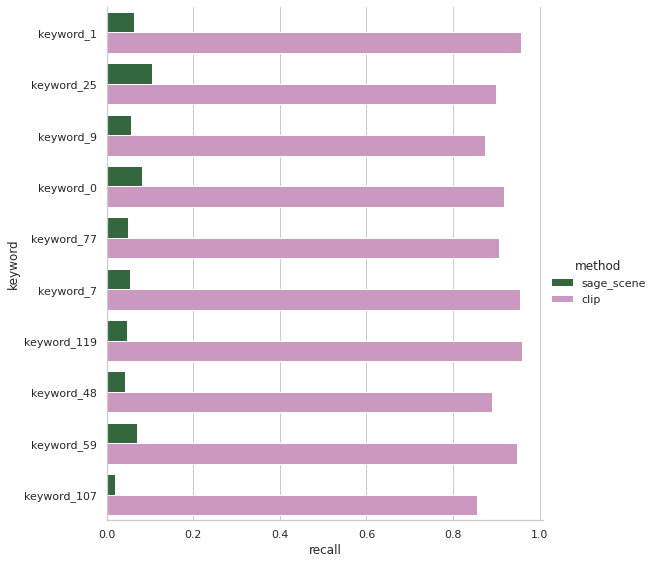

In [120]:
sns.set_theme(style="whitegrid")

def compute_f1(prec, rec):
    return 2*(prec*rec) / (prec+rec) if (prec + rec) > 0 else 0

output_dir = cfg.exp_outputs.coco if org == 'coco' else cfg.exp_outputs.zillow

if not os.path.exists(os.path.join(output_dir, 'val_prec_rec_f1_data.csv')):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    prec_rec_f1_data = pd.DataFrame(columns=['exp_name', 'precision_macro', 'recall_macro', 
                                            'f1_macro', 'precision_micro', 'recall_micro', 'f1_micro'])
else:
    prec_rec_f1_data = pd.read_csv(os.path.join(output_dir, 'val_prec_rec_f1_data.csv'))
    prec_rec_f1_data = prec_rec_f1_data[prec_rec_f1_data['exp_name']!=f'sage_{reconnection_method}']
    prec_rec_f1_data = prec_rec_f1_data[prec_rec_f1_data['exp_name']!='clip']

best_sage_results_by_keyword = results_dict[best_rows['sage']['f1_macro']['threshold']]['sage']
best_clip_results_by_keyword = results_dict[best_rows['clip']['f1_macro']['threshold']]['clip']

results_by_keyword = {f'sage_{reconnection_method}': best_sage_results_by_keyword,
                       'clip': best_clip_results_by_keyword}

for exp_name in results_by_keyword:
    exp_results = pd.DataFrame(columns=['exp_name', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_micro', 'recall_micro', 'f1_micro'])
    exp_results['precision_macro'] = [np.mean(results_by_keyword[exp_name]['precision'])]
    exp_results['recall_macro'] = [np.mean(results_by_keyword[exp_name]['recall'])]
    exp_results['f1_macro'] = exp_results.apply(lambda x: compute_f1(x['precision_macro'], x['recall_macro']), axis=1)
    exp_results['precision_micro'] = [np.mean(results_by_keyword[exp_name]['precision']*weights)]
    exp_results['recall_micro'] = [np.mean(results_by_keyword[exp_name]['recall']*weights)]
    exp_results['f1_micro'] = exp_results.apply(lambda x: compute_f1(x['precision_micro'], x['recall_micro']), axis=1)
    exp_results['exp_name'] = [exp_name]
    prec_rec_f1_data = pd.concat([prec_rec_f1_data, exp_results], ignore_index=True)

prec_rec_f1_data.to_csv(os.path.join(output_dir, 'val_prec_rec_f1_data.csv'), index=False)

if org == 'zillow':
    train_new_old_node_id_mapping_file = os.path.join(csv_dataset_root,'new_old_node_id_mapping.json')
    train_new_old_node_id_mapping = json.load(open(train_new_old_node_id_mapping_file, 'r'))
    mapper_file = 'hash_keyword_mapper.json'
    id_keyword_mapper = json.load(open(os.path.join('notebooks', mapper_file), 'r'))
    
    keyword_node_ids = eval_subgraph.nodes()[(eval_subgraph.ndata['ntype']==1).nonzero().squeeze()]
    keyword_node_ids = [train_new_old_node_id_mapping[str(key.item())] for key in keyword_node_ids]    
    
elif org == 'coco':
    mapper_file = 'tag_id_name_mapper.json'
    id_keyword_mapper = json.load(open(os.path.join('notebooks', mapper_file), 'r'))

    keyword_node_ids = eval_subgraph.ndata['_ID'][(eval_subgraph.ndata['ntype']==1).nonzero().squeeze()]
    keyword_node_ids = [str(node_id.item()) for node_id in keyword_node_ids]



keywords = [id_keyword_mapper[keyword_node_ids[i]] if keyword_node_ids[i] in list(id_keyword_mapper.keys()) 
            else f'keyword_{i}' for i in range(len(keyword_node_ids))]


by_keyword_results = pd.concat([pd.DataFrame({'keyword': keywords,
                                            'method': f'sage_{reconnection_method}',
                                            'precision': best_sage_results_by_keyword['precision'],
                                            'recall': best_sage_results_by_keyword['recall'],
                                            'weights': weights}).sort_values(by='weights', ascending=False)\
                                            .drop_duplicates(subset='keyword').head(10),
                                pd.DataFrame({'keyword': keywords,
                                            'method': 'clip',
                                            'precision': best_clip_results_by_keyword['precision'],
                                            'recall': best_clip_results_by_keyword['recall'],
                                            'weights': weights}).sort_values(by='weights', ascending=False)\
                                            .drop_duplicates(subset='keyword').head(10)]
                                )

ax_prec = sns.catplot(
    data=by_keyword_results, kind="bar",
    x="precision", y="keyword", hue="method",
    palette="cubehelix", height=8
)
ax_prec.set_axis_labels("precision", "keyword")

ax_rec = sns.catplot(
    data=by_keyword_results, kind="bar",
    x="recall", y="keyword", hue="method",
    palette="cubehelix", height=8
)

ax_rec.set_axis_labels("recall", "keyword")
plt.show()


<ins>Metrics by Experiment Type: Plot</ins>

_NOTE: This requires at least two experiments to be run within this notebook_

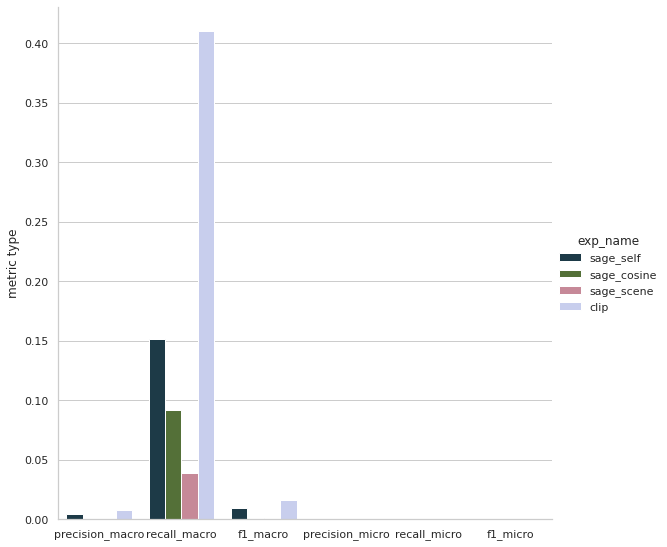

In [121]:
prec_rec_f1_data_plot = pd.melt(prec_rec_f1_data, id_vars=['exp_name'], value_vars=['precision_macro', 'recall_macro', 'f1_macro',
                                                                'precision_micro', 'recall_micro', 'f1_micro'])
                                                                
g_metrics = sns.catplot(
    data=prec_rec_f1_data_plot, kind="bar",
    x="variable", y="value", hue="exp_name",
    palette="cubehelix", height=8
)

g_metrics.set_axis_labels("", "metric type")

<ins>Metrics by Experiment Type: Tabular Form</ins>

In [122]:
prec_rec_f1_data.head()

,exp_name,precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro
0,sage_self,0.004922,0.151772,0.009535,0.000058,0.000366,0.000101
1,sage_cosine,0.000475,0.091505,0.000946,0.000005,0.000095,0.000009
2,sage_scene,0.000450,0.038582,0.000890,0.000004,0.000035,0.000007
3,clip,0.008179,0.410289,0.016038,0.000065,0.000490,0.000114


<ins>ROC Curves: Data Preperation</ins>

In [123]:
method_link_scores = {'sage': val_sage_link_scores, 'clip': val_clip_link_scores}

if not os.path.exists(os.path.join(output_dir, 'val_roc_auc_scores.json')):
    roc_auc_values = {f'sage_{reconnection_method}': {'micro': 0, 'macro': 0}, 'clip': {'micro': 0, 'macro': 0}}
else:
    roc_auc_values = json.load(open(os.path.join(output_dir, 'val_roc_auc_scores.json'), 'r'))
    
if not os.path.exists(os.path.join(output_dir, 'val_roc_data.csv')):
    roc_data = pd.DataFrame(columns=['exp_name', 'fpr_micro', 'tpr_micro'])
else:
    roc_data = pd.read_csv(os.path.join(output_dir, 'val_roc_data.csv'))
    roc_data = roc_data[roc_data['exp_name']!=f'sage_{reconnection_method}']
    roc_data = roc_data[roc_data['exp_name']!='clip']
     
for method in method_link_scores:
    fpr_micro, tpr_micro, thresholds = metrics.roc_curve(val_adj_matrix.flatten(), method_link_scores[method].flatten())
    method_roc_data = pd.DataFrame(columns=['exp_name', 'fpr_micro', 'tpr_micro'])
    exp_name = f'sage_{reconnection_method}' if method == 'sage' else 'clip'
    
    roc_auc_values[exp_name] = {'micro': 0, 'macro': 0} # overwrite old results
    
    method_roc_data['fpr_micro'] = fpr_micro
    method_roc_data['tpr_micro'] = tpr_micro
    method_roc_data['exp_name'] = exp_name
    
    roc_data = pd.concat([roc_data, method_roc_data])
    
    roc_auc_values[exp_name]['micro'] = metrics.auc(fpr_micro, tpr_micro)

    # keyword_aucs = []
    # for i in range(method_link_scores[method].shape[0]):
    #     keyword_aucs.append(metrics.roc_auc_score(val_adj_matrix[i], method_link_scores[method][i]))
    # roc_auc_values[exp_name]['macro'] = np.mean(keyword_aucs)

#roc_data.drop_duplicates(subset='exp_name', keep='last', inplace=True)
roc_data.to_csv(os.path.join(output_dir, 'val_roc_data.csv'), index=False)

with open(os.path.join(output_dir, 'val_roc_auc_scores.json'), 'w') as outfile:
    json.dump(roc_auc_values, outfile)

<ins>ROC Curves: Plots</ins>

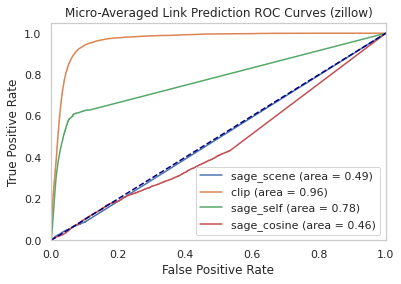

In [124]:
for exp in set(roc_data['exp_name'].values):
    exp_data = roc_data[roc_data['exp_name']==exp]
    plt.plot(exp_data['fpr_micro'], exp_data['tpr_micro'], label=f"{exp} (area = %0.2f)" % roc_auc_values[exp]['micro'])

plt.grid(False)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Micro-Averaged Link Prediction ROC Curves ({org})")
plt.legend(loc="lower right")
plt.show()

<ins>ROC Curves: Data</ins>

In [125]:
print('ROC AUC Scores:', roc_auc_values)

ROC AUC Scores: {'sage_scene': {'micro': 0.49418439338889414, 'macro': 0}, 'clip': {'micro': 0.9649549583135297, 'macro': 0}, 'sage_cosine': {'micro': 0.4565764730955176, 'macro': 0}, 'sage_self': {'micro': 0.7790267000087452, 'macro': 0}}


# Evaluation on Holdout Set

_Note: This is for Zillow data only_


<ins>Define Data Objects and Subgraphs</ins>

In [126]:
cfg = NestedNamespace(yaml.load(open('conf/config.yaml'), Loader=Loader))
val_csv_dataset_root = cfg.graph.zillow_verified.graph_dir

test_modal_node_ids_file = os.path.join(val_csv_dataset_root,'modal_node_ids.json')
test_new_old_node_id_mapping_file = os.path.join(val_csv_dataset_root,'new_old_node_id_mapping.json')
test_datamodule = DataModule(
    val_csv_dataset_root, 
    modal_node_ids_file, 
    keyword_as_src=False, 
    device=device, 
    batch_size=cfg.training.batch_size, 
    force_reload=False
)

test_subgraph = test_datamodule.g_bid
test_eval_subgraph = datamodule.g_bid.subgraph(datamodule.g_bid.nodes())
test_eval_subgraph.ndata['test_mask'] = torch.zeros(len(test_eval_subgraph.nodes()), dtype=torch.uint8).to(device)
print(len(test_eval_subgraph.ndata['test_mask']))

test_img_node_idxs = (test_subgraph.ndata['ntype'] == 0).nonzero().squeeze()
test_img_embeds = test_subgraph.ndata['feat'][test_img_node_idxs]
test_img_node_ids = test_subgraph.nodes()[test_img_node_idxs] + torch.max(test_eval_subgraph.nodes()) + 1

print('number of test img nodes:', len(test_img_node_ids))
print('number of "train" img nodes:', len(test_eval_subgraph.nodes()))

test_nodes_data = {'train_mask': torch.zeros(len(test_img_node_ids), dtype=torch.uint8).to(device),
                   'val_mask': torch.zeros(len(test_img_node_ids), dtype=torch.uint8).to(device),
                   'test_mask': torch.ones(len(test_img_node_ids), dtype=torch.uint8).to(device),
                   'ntype': torch.zeros(len(test_img_node_ids), dtype=torch.int64).to(device),
                   'feat': test_img_embeds.to(device),
                   '_ID': test_img_node_ids}

test_eval_subgraph.add_nodes(num=len(test_img_node_ids), data=test_nodes_data)

Done loading data from cached files.
84270
number of test img nodes: 9206
number of "train" img nodes: 84270


<ins>Here, we are redoing the following cells from above, except on the held out data. We do this in one single cell for output condensation.</ins>

Identifying Node Pairs as Edges 

Collect Edges for Subgraph

In [127]:
# get node ID to hash ID mappings to find in-vocabulary keywords and scenes from test dataset

test_keyword_ids = test_subgraph.nodes()[(test_subgraph.ndata['ntype']==1).nonzero().squeeze()].cpu().detach().tolist()
test_new_old_node_id_mapping = json.load(open(test_new_old_node_id_mapping_file, 'r'))
test_old_new_node_id_mapping = {v: k for k, v in test_new_old_node_id_mapping.items()}

train_new_old_node_id_mapping_file = os.path.join(csv_dataset_root,'new_old_node_id_mapping.json')
train_new_old_node_id_mapping = json.load(open(train_new_old_node_id_mapping_file, 'r'))
train_old_new_node_id_mapping = {v: k for k, v in train_new_old_node_id_mapping.items()}


if reconnection_method == 'cosine':
    # Step 3: Identify image node pairs as edges

    eval_train_img_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 0)&(test_eval_subgraph.ndata['test_mask']==0)).nonzero().squeeze()
    eval_train_kw_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 1)&(test_eval_subgraph.ndata['test_mask']==0)).nonzero().squeeze()
    eval_test_img_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 0)&(test_eval_subgraph.ndata['test_mask']==1)).nonzero().squeeze()
    
    eval_train_img_embeds = test_eval_subgraph.ndata['feat'][eval_train_img_node_idxs]
    eval_train_kw_embeds = test_eval_subgraph.ndata['feat'][eval_train_kw_node_idxs]
    eval_test_img_embeds = test_eval_subgraph.ndata['feat'][eval_test_img_node_idxs]

    cosine_sims_img_matrix = cosine_sim(eval_test_img_embeds, eval_train_img_embeds)
    cosine_sims_img_kw_matrix = cosine_sim(eval_test_img_embeds, eval_train_kw_embeds)
    print(eval_test_img_embeds.size())
    print(cosine_sims_img_matrix.size())

    img_sim_threshold = 0.98
    img_img_k = 5
    img_kw_k = 5
            
    test_eval_matches = []
    for i in tqdm(range(cosine_sims_img_matrix.size(0)), desc='computing image-image matches'):
        # get val img to train img matches
        eval_train_img_node_id_matches = eval_train_img_node_idxs[(cosine_sims_img_matrix[i]>img_sim_threshold)]

        if len(eval_train_img_node_id_matches) < img_img_k:
            img_matches, img_match_indices = torch.topk(cosine_sims_img_matrix[i], img_img_k)
            eval_train_img_node_id_matches = eval_train_img_node_idxs[img_match_indices]
        
        # get val img to train keyword matches
        kw_matches, kw_match_indices = torch.topk(cosine_sims_img_kw_matrix[i], img_kw_k)
        
        eval_train_kw_node_id_matches = eval_train_kw_node_idxs[kw_match_indices]

        eval_train_node_id_matches = torch.cat((eval_train_img_node_id_matches, eval_train_kw_node_id_matches))
        test_eval_matches.append(eval_train_node_id_matches.tolist())

    test_matches_per_img = [len(match_list) for match_list in test_eval_matches]


if reconnection_method == 'scene':
    # Step 3: Identify image and scene node pairs as edges

    eval_train_img_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 0)&(test_eval_subgraph.ndata['test_mask']==0)).nonzero().squeeze()
    eval_train_scene_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 2)&(test_eval_subgraph.ndata['test_mask']==0)).nonzero().squeeze()

    eval_test_img_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 0)&(test_eval_subgraph.ndata['test_mask']==1)).nonzero().squeeze()
    
    eval_train_img_ids = test_eval_subgraph.ndata['_ID'][eval_train_img_node_idxs]
    eval_train_scene_ids = test_eval_subgraph.ndata['_ID'][eval_train_scene_node_idxs]

    eval_test_img_ids = test_eval_subgraph.ndata['_ID'][eval_test_img_node_idxs]
    test_img_ids = (test_subgraph.ndata['ntype'] == 0).nonzero().squeeze()
    test_scene_ids = (test_subgraph.ndata['ntype'] == 2).nonzero().squeeze()

    train_scene_hashes = [train_new_old_node_id_mapping[str(key.item())] for key in eval_train_scene_ids]
    test_scene_hashes = [test_new_old_node_id_mapping[str(key.item())] for key in test_scene_ids]
    test_train_scene_node_mapper = {}

    for i in range(len(test_scene_hashes)):
        if test_scene_hashes[i] in train_scene_hashes:
            test_node_id = test_old_new_node_id_mapping[str(test_scene_hashes[i])]
            train_node_id = train_old_new_node_id_mapping[str(test_scene_hashes[i])]
            test_train_scene_node_mapper[int(test_node_id)] = int(train_node_id)

    def get_scene_edges_test(node_id, eval_graph, test_graph, eval_train_scene_ids, eval_test_scene_ids,
                             test_train_scene_node_mapper):
                             
        u_node, v_node = test_graph.edges()
        u_node_edge_idxs = torch.nonzero(node_id == u_node)
        v_ids = v_node[u_node_edge_idxs]

        v_node_edge_idxs = torch.nonzero(node_id == v_node)
        u_ids = u_node[v_node_edge_idxs]

        all_edge_ids = torch.cat([u_ids, v_ids], dim=0)
        
        indices = torch.zeros_like(all_edge_ids, dtype = torch.uint8, device = device)
        for elem in eval_test_scene_ids:
            indices = indices | (all_edge_ids == elem)

        intersection = [node for node in all_edge_ids[indices].cpu().detach().tolist() if node in list(test_train_scene_node_mapper.keys())]
        intersection_mapped = torch.LongTensor([test_train_scene_node_mapper[key] for key in intersection])
        
        return torch.unique(intersection_mapped)

    ## every eval-validation image:
    ##### find all eval-train scenes it is connected to in the eval_subgraph
    ##### connect the image-scene 

    u_test = []
    v_test = []

    for test_img_id in tqdm(test_img_ids):
        matching_eval_train_scenes = get_scene_edges_test(test_img_id, test_eval_subgraph, test_subgraph, 
                                                          eval_train_scene_ids, test_scene_ids, test_train_scene_node_mapper)

        if matching_eval_train_scenes.size(dim=0) > 0:
            for scene in matching_eval_train_scenes:
                u_test += [test_img_id.item(), scene.item()]
                v_test += [scene.item(), test_img_id.item()]

if reconnection_method == 'cosine':

    u_test = []
    v_test = []

    for i in range(len(test_eval_matches)):
        test_img_node = eval_test_img_node_idxs[i].item()
        train_matches = test_eval_matches[i]
        for node_id in train_matches:
            train_img_node = node_id
            # Add bidirectional edge for each match
            u_test += [test_img_node, train_img_node]
            v_test += [train_img_node, test_img_node]
    
if reconnection_method == 'cosine' or reconnection_method == 'scene':
    test_edge_data = {'_ID': torch.arange(torch.max(test_eval_subgraph.edata['_ID'])+1, torch.max(test_eval_subgraph.edata['_ID'])+1+len(u_test), dtype=torch.int64).to(device)}
    test_eval_subgraph.add_edges(torch.LongTensor(u_test).to(device), torch.LongTensor(v_test).to(device), data=test_edge_data)

test_eval_subgraph = test_eval_subgraph.add_self_loop()

100%|██████████| 9206/9206 [00:07<00:00, 1309.30it/s]


<ins> Make DGL Graph GraphSAGE Compliant and Run Inference</ins>

In [128]:
# Step 5: Turn DGL graph into DataLoader object for GraphSAGE forward inference

u_test_eval, v_test_eval = test_eval_subgraph.edges()
test_eval_subgraph_eids = test_eval_subgraph.edge_ids(u_test_eval, v_test_eval)
layer_sampler = dgl.dataloading.NeighborSampler(fanouts=[3]) # During message passing between GNN layers, each node accept messages from a maximum of 25 incoming nodes
batch_size = len(test_eval_subgraph_eids)

def test_eval_dataloader(g, layer_sampler, batch_size, eids):
    edge_sampler = dgl.dataloading.as_edge_prediction_sampler(layer_sampler)

    return dgl.dataloading.DataLoader(
        g,
        eids,
        edge_sampler,
        device=device,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
        # num_workers=self.num_workers,
    )

test_eval_dl = test_eval_dataloader(test_eval_subgraph, layer_sampler, batch_size, test_eval_subgraph_eids)

# Step 6: Run graphSAGE forward inference over entire val_subgraph message flow graph (MFG)

for batch in test_eval_dl:
    # This loop only runs once b/c batch_size = number of total edges in train_val_subgraph - we only need it to get "blocks"
    test_inputs, test_edge_subgraph, test_blocks = batch
    
x = test_blocks[0].srcdata["feat"]
model = model.to(device)
logits = model(test_blocks, x)

test_eval_subgraph.ndata['feat_pred'] = logits

<ins>Additional Work for Metric Generation</ins>

In [129]:
eval_test_img_node_ids = ((test_eval_subgraph.ndata['test_mask']==1)&(test_eval_subgraph.ndata['ntype']==0)).nonzero().squeeze()
eval_keyword_node_ids = ((test_eval_subgraph.ndata['ntype']==1)).nonzero().squeeze()

test_keyword_hashes = [test_new_old_node_id_mapping[str(key)] for key in test_keyword_ids]
train_keyword_hashes = [train_new_old_node_id_mapping[str(key.item())] for key in eval_keyword_node_ids]

train_overlap_ids = []
for i in range(len(train_keyword_hashes)):
    if train_keyword_hashes[i] in test_keyword_hashes:
        train_overlap_ids.append(eval_keyword_node_ids[i])
eval_test_keyword_node_ids = torch.LongTensor(train_overlap_ids)

test_overlap_ids = []
for i in range(len(test_keyword_hashes)):
    if test_keyword_hashes[i] in train_keyword_hashes:
        test_overlap_ids.append(test_keyword_ids[i])
test_keyword_node_ids = torch.LongTensor(test_overlap_ids)

# Post-GraphSAGE embeddings
eval_test_img_feat_sage = test_eval_subgraph.ndata['feat_pred'][eval_test_img_node_ids]
eval_keyword_feat_sage = test_eval_subgraph.ndata['feat_pred'][eval_test_keyword_node_ids]

# Original CLIP embeddings before GraphSAGE forward method
eval_test_img_feat_clip = test_eval_subgraph.ndata['feat'][eval_test_img_node_ids]
eval_keyword_feat_clip = test_eval_subgraph.ndata['feat'][eval_test_keyword_node_ids]

# Step 8: Compute cosine similarities between validation images and keywords to get "link scores" between 0 and 1
test_sage_link_scores = cosine_sim(eval_keyword_feat_sage, eval_test_img_feat_sage).cpu().detach().numpy()
test_clip_link_scores = cosine_sim(eval_keyword_feat_clip, eval_test_img_feat_clip).cpu().detach().numpy()

In [130]:
# Adjacency matrix needs to be sub-setted such that rows correspond only to image nodes and columns correspond only to keyword nodes
test_img_indices = (test_subgraph.ndata['ntype']==0).nonzero().cpu().reshape(1, -1)
test_keyword_indices = test_keyword_node_ids.reshape(-1, 1)

test_adj_matrix = test_subgraph.adjacency_matrix().to_dense().numpy()
test_adj_matrix = test_adj_matrix[test_keyword_indices, test_img_indices]

method_link_scores = {'sage': test_sage_link_scores, 'clip': test_clip_link_scores}

pred_thresholds = np.linspace(0.1, 0.9, 50)
test_sage_clip_metrics = pd.DataFrame()
results_dict = {threshold: {} for threshold in pred_thresholds}

for pred_threshold in pred_thresholds:
    results_dict[pred_threshold] = {'sage': {}, 'clip': {}}

    for method in method_link_scores:
        method_link_predictions = (method_link_scores[method] > pred_threshold).astype(int)
        n_keywords = len(method_link_scores[method])
        for metric in ['tp', 'fp', 'fn', 'actual_p', 'precision', 'recall', 'f1']:
            results_dict[pred_threshold][method][metric] = np.empty(n_keywords)
        weights = np.empty(n_keywords)
        
        for i in range(n_keywords):
            all_p = np.sum(test_adj_matrix[i])
            all_p_pred = np.sum(method_link_predictions[i])
            results_dict[pred_threshold][method]['tp'][i] = np.sum((method_link_predictions[i]==1)&(test_adj_matrix[i]==1))
            results_dict[pred_threshold][method]['fp'][i] = np.sum((method_link_predictions[i]==1)&(test_adj_matrix[i]==0))
            results_dict[pred_threshold][method]['fn'][i] = np.sum((method_link_predictions[i]==0)&(test_adj_matrix[i]==1))
            results_dict[pred_threshold][method]['actual_p'][i] = all_p

            precision = results_dict[pred_threshold][method]['tp'][i] / all_p_pred if all_p_pred > 0 else 0
            recall = results_dict[pred_threshold][method]['tp'][i] / all_p if all_p > 0 else 0

            results_dict[pred_threshold][method]['precision'][i] = precision
            results_dict[pred_threshold][method]['recall'][i] = recall

            weights[i] = all_p

    weights /= np.sum(weights)

    for method in results_dict[pred_threshold].keys():
        row = {'threshold': pred_threshold, 'method': method}
        for metric in results_dict[pred_threshold][method]:
            if metric == 'precision' or metric == 'recall' or metric == 'f1':
                row[f'{metric}_micro'] = np.mean(results_dict[pred_threshold][method][metric]*weights)
                row[f'{metric}_macro'] = np.mean(results_dict[pred_threshold][method][metric])
        
        row['f1_micro'] = 2*(row['precision_micro']*row['recall_micro']) / (row['precision_micro']+row['recall_micro']) if (row['precision_micro']+row['recall_micro']) > 0 else 0
        row['f1_macro'] = 2*(row['precision_macro']*row['recall_macro']) / (row['precision_macro']+row['recall_macro']) if (row['precision_macro']+row['recall_macro']) > 0 else 0
        test_sage_clip_metrics = pd.concat([test_sage_clip_metrics, pd.DataFrame([row])], ignore_index=True)

test_sage_metrics = test_sage_clip_metrics[(test_sage_clip_metrics['method']=='sage')]
test_clip_metrics = test_sage_clip_metrics[(test_sage_clip_metrics['method']=='clip')]

<ins>Summary Metrics</ins>

In [131]:
print('Best SAGE metrics: ')
macro_metrics = ['recall_macro', 'precision_macro', 'f1_macro']
metrics_dfs = {'sage': test_sage_metrics, 'clip': test_clip_metrics}
best_rows = {}
for method in ['sage', 'clip']:
    best_rows[method] = {}
    metric_df = metrics_dfs[method]
    for metric in macro_metrics:
        best_rows[method][metric] = metric_df[metric_df[metric]==metric_df[metric].max()][['threshold']+macro_metrics].iloc[0,:]
        print(f'Metrics at best {metric}:\n', best_rows[method][metric])

Best SAGE metrics: 
Metrics at best recall_macro:
 threshold          0.100000
recall_macro       0.619279
precision_macro    0.350896
f1_macro           0.447966
Name: 0, dtype: float64
Metrics at best precision_macro:
 threshold          0.900000
recall_macro       0.566617
precision_macro    0.376907
f1_macro           0.452690
Name: 98, dtype: float64
Metrics at best f1_macro:
 threshold          0.785714
recall_macro       0.582793
precision_macro    0.371010
f1_macro           0.453390
Name: 84, dtype: float64
Metrics at best recall_macro:
 threshold          0.100000
recall_macro       1.000000
precision_macro    0.131197
f1_macro           0.231961
Name: 1, dtype: float64
Metrics at best precision_macro:
 threshold          0.410204
recall_macro       0.162136
precision_macro    0.400104
f1_macro           0.230760
Name: 39, dtype: float64
Metrics at best f1_macro:
 threshold          0.393878
recall_macro       0.606417
precision_macro    0.363880
f1_macro           0.454836
N

## Holdout Dataset Plots

<ins> Micro and Macro Precision and Recall: Plots </ins>

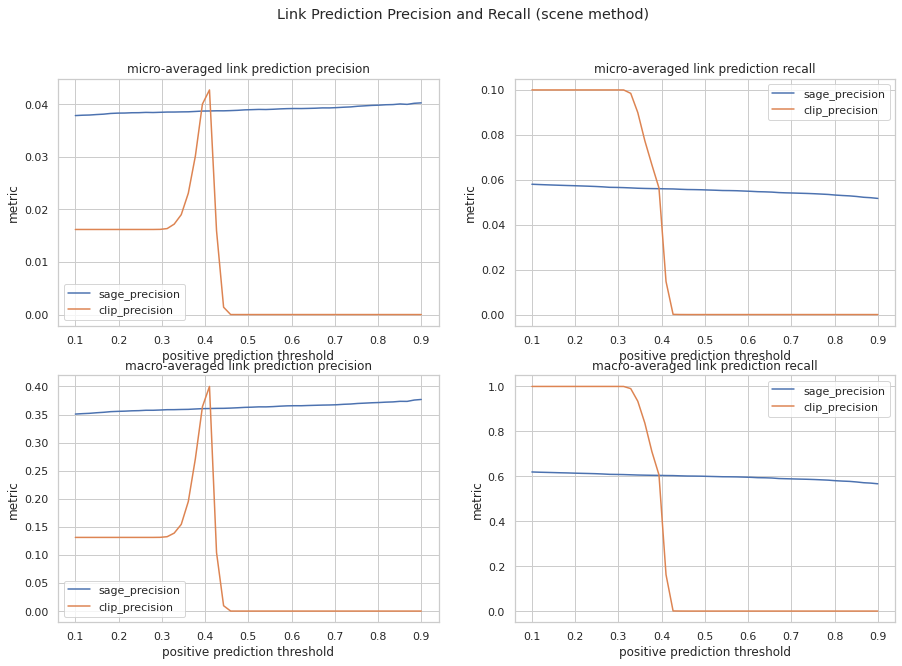

In [132]:
import matplotlib.pyplot as plt

# test_sage_micro_threshold_metrics = test_sage_clip_metrics[test_sage_clip_metrics['method']=='sage'][['threshold', 'precision_micro', 'recall_micro']]
# test_clip_micro_threshold_metrics = test_sage_clip_metrics[test_sage_clip_metrics['method']=='clip'][['threshold', 'precision_micro', 'recall_micro']]
# test_sage_macro_threshold_metrics = test_sage_clip_metrics[test_sage_clip_metrics['method']=='sage'][['threshold', 'precision_macro', 'recall_macro']]
# test_clip_macro_threshold_metrics = test_sage_clip_metrics[test_sage_clip_metrics['method']=='sage'][['threshold', 'precision_macro', 'recall_macro']]

fig, axs = plt.subplots(2, 2, figsize=(15,10))
for i, avg_type in enumerate(['micro', 'macro']):
    legend = []
    for j, metric in enumerate(['precision', 'recall']):
        for method in ['sage', 'clip']:
            axs[i,j].plot(test_sage_clip_metrics[test_sage_clip_metrics['method']==method]['threshold'], 
                    test_sage_clip_metrics[test_sage_clip_metrics['method']==method][f'{metric}_{avg_type}'])
            legend += [f'{method}_{metric}']
        axs[i,j].legend(legend)
        axs[i,j].set_xlabel('positive prediction threshold')
        axs[i,j].set_ylabel('metric')
        axs[i,j].set_title(f'{avg_type}-averaged link prediction {metric}')
fig.suptitle(f'Link Prediction Precision and Recall ({reconnection_method} method)')
plt.show()


<ins> Micro and Macro Precision and Recall: By Keyword </ins>

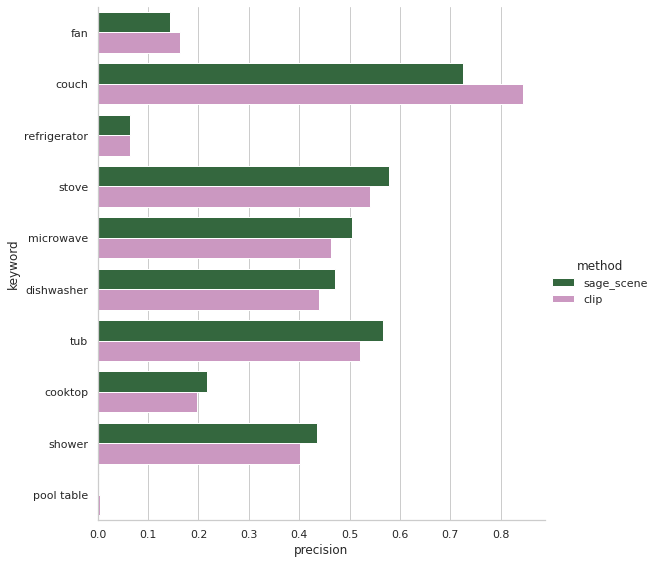

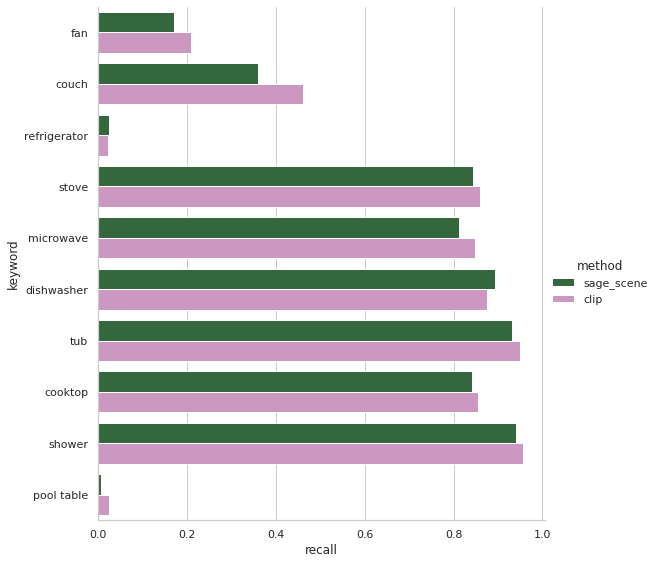

In [133]:
import seaborn as sns
sns.set_theme(style="whitegrid")
#sns.color_palette("rocket", as_cmap=True)

test_output_dir = cfg.exp_outputs.zillow_verified
if not os.path.exists(os.path.join(test_output_dir, 'test_prec_rec_f1_data.csv')):
    if not os.path.exists(test_output_dir):
        os.mkdir(test_output_dir)
    prec_rec_f1_data = pd.DataFrame(columns=['exp_name', 'precision_macro', 'recall_macro', 
                                            'f1_macro', 'precision_micro', 'recall_micro', 'f1_micro'])
else:
    prec_rec_f1_data = pd.read_csv(os.path.join(test_output_dir, 'test_prec_rec_f1_data.csv'))
    prec_rec_f1_data = prec_rec_f1_data[prec_rec_f1_data['exp_name']!=f'sage_{reconnection_method}']
    prec_rec_f1_data = prec_rec_f1_data[prec_rec_f1_data['exp_name']!='clip']

best_sage_results_by_keyword = results_dict[best_rows['sage']['f1_macro']['threshold']]['sage']
best_clip_results_by_keyword = results_dict[best_rows['clip']['f1_macro']['threshold']]['clip']

results_by_keyword = {f'sage_{reconnection_method}': best_sage_results_by_keyword,
                      'clip': best_clip_results_by_keyword}

for exp_name in results_by_keyword:
    exp_results = pd.DataFrame(columns=['exp_name', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_micro', 'recall_micro', 'f1_micro'])
    exp_results['precision_macro'] = [np.mean(results_by_keyword[exp_name]['precision'])]
    exp_results['recall_macro'] = [np.mean(results_by_keyword[exp_name]['recall'])]
    exp_results['f1_macro'] = exp_results.apply(lambda x: compute_f1(x['precision_macro'], x['recall_macro']), axis=1)
    exp_results['precision_micro'] = [np.mean(results_by_keyword[exp_name]['precision']*weights)]
    exp_results['recall_micro'] = [np.mean(results_by_keyword[exp_name]['recall']*weights)]
    exp_results['f1_micro'] = exp_results.apply(lambda x: compute_f1(x['precision_micro'], x['recall_micro']), axis=1)
    exp_results['exp_name'] = [exp_name]
    prec_rec_f1_data = pd.concat([prec_rec_f1_data, exp_results], ignore_index=True)

prec_rec_f1_data.to_csv(os.path.join(test_output_dir, 'test_prec_rec_f1_data.csv'), index=False)

keyword_hashes = [test_new_old_node_id_mapping[str(key.item())] for key in test_keyword_node_ids]
hash_keyword_mapper = json.load(open('notebooks/hash_keyword_mapper.json', 'r'))
keyword_hashes_mask = [hash_keyword_mapper[keyword_hashes[i]] if keyword_hashes[i] in list(hash_keyword_mapper.keys())
                         else f'keyword_{i}' for i in range(len(keyword_hashes))]

by_keyword_results = pd.concat([pd.DataFrame({'keyword_hash': keyword_hashes_mask,
                                              'method': f'sage_{reconnection_method}',
                                              'precision': best_sage_results_by_keyword['precision'],
                                              'recall': best_sage_results_by_keyword['recall'],
                                              'weights': weights}).sort_values(by='weights', ascending=False),
                                pd.DataFrame({'keyword_hash': keyword_hashes_mask,
                                              'method': 'clip',
                                              'precision': best_clip_results_by_keyword['precision'],
                                              'recall': best_clip_results_by_keyword['recall'],
                                              'weights': weights}).sort_values(by='weights', ascending=False)])

ax_prec = sns.catplot(
    data=by_keyword_results, kind="bar",
    x="precision", y="keyword_hash", hue="method",
    palette="cubehelix", height=8
)
ax_prec.set_axis_labels("precision", "keyword")

ax_rec = sns.catplot(
    data=by_keyword_results, kind="bar",
    x="recall", y="keyword_hash", hue="method",
    palette="cubehelix", height=8
)

ax_rec.set_axis_labels("recall", "keyword")


<ins>Plots by Experiment Type</ins>

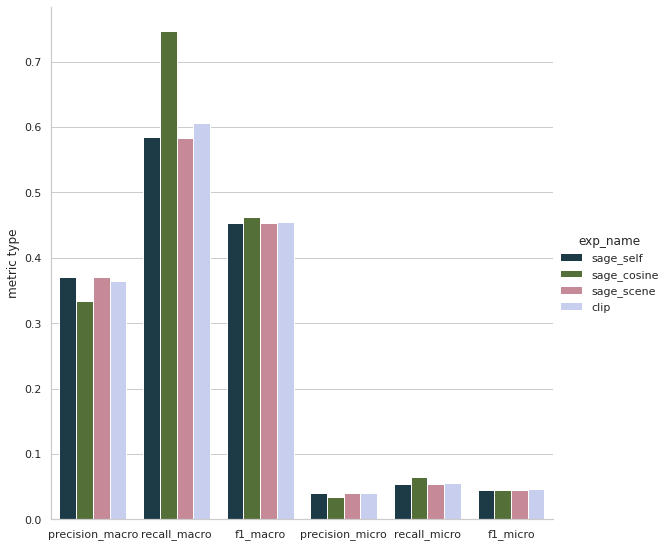

In [134]:
prec_rec_f1_data_plot = pd.melt(prec_rec_f1_data, id_vars=['exp_name'], value_vars=['precision_macro', 'recall_macro', 'f1_macro',
                                                                'precision_micro', 'recall_micro', 'f1_micro'])

g_metrics = sns.catplot(
    data=prec_rec_f1_data_plot, kind="bar",
    x="variable", y="value", hue="exp_name",
    palette="cubehelix", height=8
)
#plt.title('Link Prediction Metrics At Best F1 Score')
g_metrics.set_axis_labels("", "metric type")

<ins>Data by Experiment Type</ins>

In [135]:
prec_rec_f1_data

,exp_name,precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro
0,sage_self,0.370456,0.584299,0.453429,0.039708,0.053643,0.045636
1,sage_cosine,0.334199,0.746521,0.461704,0.034174,0.064829,0.044756
2,sage_scene,0.371010,0.582793,0.453390,0.039782,0.053469,0.045621
3,clip,0.363880,0.606417,0.454836,0.040030,0.056375,0.046817


<ins>ROC Curves: Data Preprocessing</ins>

In [136]:
method_link_scores = {'sage': test_sage_link_scores, 'clip': test_clip_link_scores}

if not os.path.exists(os.path.join(test_output_dir,'test_roc_auc_scores.json')):
    roc_auc_values = {f'sage_{reconnection_method}': {'micro': 0, 'macro': 0}, 'clip': {'micro': 0, 'macro': 0}}
else:
    roc_auc_values = json.load(open(os.path.join(test_output_dir,'test_roc_auc_scores.json'), 'r'))
    
if not os.path.exists(os.path.join(test_output_dir, 'test_roc_data.csv')):
    roc_data = pd.DataFrame(columns=['exp_name', 'fpr_micro', 'tpr_micro'])
else:
    roc_data = pd.read_csv(os.path.join(test_output_dir,'test_roc_data.csv'))
    roc_data = roc_data[roc_data['exp_name']!=f'sage_{reconnection_method}']
    roc_data = roc_data[roc_data['exp_name']!='clip']
     
for method in method_link_scores:
    fpr_micro, tpr_micro, thresholds = metrics.roc_curve(test_adj_matrix.flatten(), method_link_scores[method].flatten())
    method_roc_data = pd.DataFrame(columns=['exp_name', 'fpr_micro', 'tpr_micro'])
    exp_name = f'sage_{reconnection_method}' if method == 'sage' else 'clip'
    
    roc_auc_values[exp_name] = {'micro': 0, 'macro': 0} # overwrite old results
    
    method_roc_data['fpr_micro'] = fpr_micro
    method_roc_data['tpr_micro'] = tpr_micro
    method_roc_data['exp_name'] = exp_name
    
    roc_data = pd.concat([roc_data, method_roc_data])
    
    roc_auc_values[exp_name]['micro'] = metrics.auc(fpr_micro, tpr_micro)

    keyword_aucs = []
    for i in range(method_link_scores[method].shape[0]):
        keyword_aucs.append(metrics.roc_auc_score(test_adj_matrix[i], method_link_scores[method][i]))
    roc_auc_values[exp_name]['macro'] = np.mean(keyword_aucs)

#roc_data.drop_duplicates(subset='exp_name', keep='last', inplace=True)
roc_data.to_csv(os.path.join(test_output_dir,'test_roc_data.csv'), index=False)
print(len(roc_data))

with open(os.path.join(test_output_dir,'test_roc_auc_scores.json'), 'w') as outfile:
    json.dump(roc_auc_values, outfile)

50114


<ins>ROC Curves: Plots</ins>

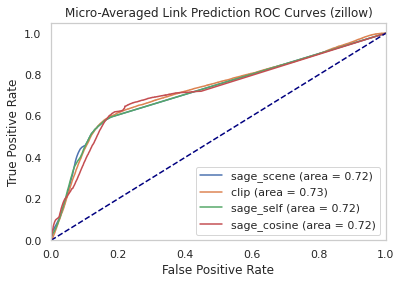

In [137]:
for exp in set(roc_data['exp_name'].values):
    exp_data = roc_data[roc_data['exp_name']==exp]
    plt.plot(exp_data['fpr_micro'], exp_data['tpr_micro'], label=f"{exp} (area = %0.2f)" % roc_auc_values[exp]['micro'])

plt.grid(False)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Micro-Averaged Link Prediction ROC Curves ({org})")
plt.legend(loc="lower right")
plt.show()

<ins>ROC Curves: Values</ins>

In [138]:
roc_auc_values

{'sage_scene': {'micro': 0.722043504352977, 'macro': 0.7362383234962149},
 'clip': {'micro': 0.7258953221214299, 'macro': 0.7492136590314253},
 'sage_cosine': {'micro': 0.7195854220991742, 'macro': 0.7580921547627988},
 'sage_self': {'micro': 0.7213260806582624, 'macro': 0.7359250830307833}}

# **Additional Analysis**

## UMAP Plots

In [139]:
# Get one positive and negative keyword-image pair for each keyword
pos_pairs = []
neg_pairs = []
for i in range(test_adj_matrix.shape[0]):
    kw_edges = test_adj_matrix[i]
    pos_matches = kw_edges.nonzero()[0]
    neg_matches = (kw_edges==0).nonzero()[0]
    pos_pairs.append((i,np.random.choice(pos_matches, 1)[0]))
    neg_pairs.append((i,np.random.choice(neg_matches, 1)[0]))

# Get src, pos_dst, and neg_dst node IDs
node_embeds_dict = {'src': {'feat': torch.empty((len(pos_pairs), 512)), 'feat_pred': torch.empty((len(pos_pairs), 512))}, 
                    'pos_dst': {'feat': torch.empty((len(pos_pairs), 512)), 'feat_pred': torch.empty((len(pos_pairs), 512))}, 
                    'neg_dst': {'feat': torch.empty((len(neg_pairs), 512)), 'feat_pred': torch.empty((len(neg_pairs), 512))}}

for i in range(len(pos_pairs)):
    src_idx, pos_dst_idx = pos_pairs[i]
    _, neg_dst_idx = neg_pairs[i]
    for embed_type in ['feat', 'feat_pred']:
        node_embeds_dict['src'][embed_type][i] = test_eval_subgraph.ndata[embed_type][eval_test_keyword_node_ids[src_idx]]
        node_embeds_dict['pos_dst'][embed_type][i] = test_eval_subgraph.ndata[embed_type][eval_test_img_node_ids[pos_dst_idx]]
        node_embeds_dict['neg_dst'][embed_type][i] = test_eval_subgraph.ndata[embed_type][eval_test_img_node_ids[neg_dst_idx]]



In [140]:
pos_matrix_feat = torch.cat((node_embeds_dict['src']['feat'], node_embeds_dict['pos_dst']['feat']))
pos_matrix_feat_pred = torch.cat((node_embeds_dict['src']['feat_pred'], node_embeds_dict['pos_dst']['feat_pred']))

neg_matrix_feat = torch.cat((node_embeds_dict['src']['feat'], node_embeds_dict['neg_dst']['feat']))
neg_matrix_feat_pred = torch.cat((node_embeds_dict['src']['feat_pred'], node_embeds_dict['neg_dst']['feat_pred']))

In [141]:
%pylab inline 
import umap
from umap import UMAP
import matplotlib.pyplot as plt

def umap_plot(weight_matrix1, weight_matrix2, pair_ids, title):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced1 = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix1.detach().cpu().numpy())
    reduced2 = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix2.detach().cpu().numpy())
    plt.figure(figsize=(10,10))

    plt.scatter(reduced1[:, 0], reduced1[:, 1], c=pair_ids, alpha=0.2)
    for i, pair_id in enumerate(pair_ids):
        current_point = reduced1[i]
        plt.annotate(pair_ids[i], (current_point[0], current_point[1]), fontsize=15)

    plt.scatter(reduced2[:, 0], reduced2[:, 1], c=pair_ids, alpha=1)
    for i, pair_id in enumerate(pair_ids):
        current_point = reduced2[i]
        plt.annotate(pair_ids[i], (current_point[0], current_point[1]), fontsize=15)

    plt.grid()
    plt.title(title)
    plt.show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


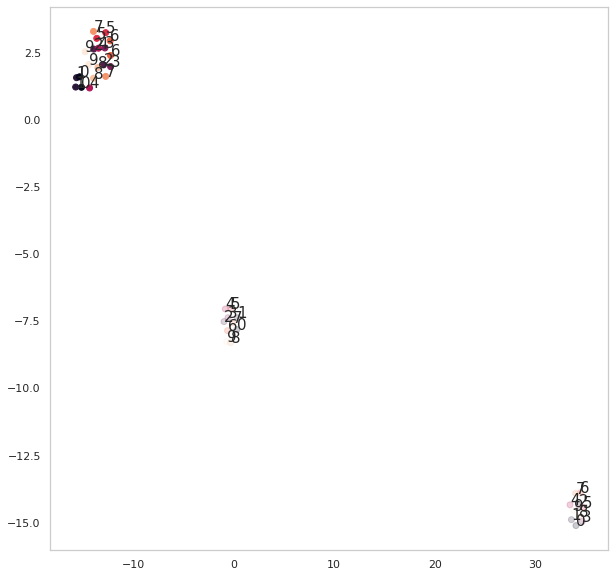

In [142]:
pair_ids = list(range(len(pos_pairs)))*2

umap_plot(pos_matrix_feat, pos_matrix_feat_pred, pair_ids, title='')
#umap_plot(pos_matrix_feat_pred, pair_ids, title='2D-projected node embeddings (positive pairs) after GraphSAGE')

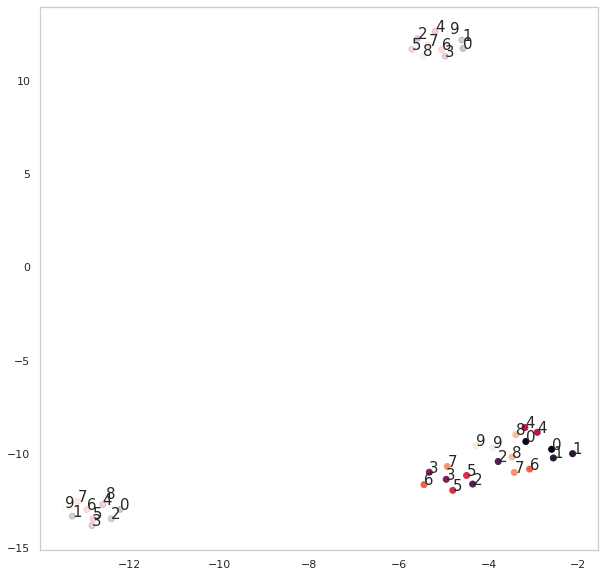

In [143]:
umap_plot(neg_matrix_feat, neg_matrix_feat_pred, pair_ids, title='')

## Tabular Metric Summarization (Embedding Similarity)

In [144]:
pos_sim_CLIP = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat'].detach().cpu().numpy(), 
                                                  node_embeds_dict['pos_dst']['feat'].detach().cpu().numpy())
pos_sim_SAGE = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat_pred'].detach().cpu().numpy(), 
                                                  node_embeds_dict['pos_dst']['feat_pred'].detach().cpu().numpy())

neg_sim_CLIP = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat'].detach().cpu().numpy(), 
                                                  node_embeds_dict['neg_dst']['feat'].detach().cpu().numpy())
neg_sim_SAGE = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat_pred'].detach().cpu().numpy(), 
                                                  node_embeds_dict['neg_dst']['feat_pred'].detach().cpu().numpy())

In [145]:
# For 10 samples, get pct change in pairwise cosine similarity for true src-dst pairs and negative pairs

import pandas as pd
from sklearn import metrics

cos_similarities = pd.DataFrame()

pos_sim_CLIP = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat'].detach().cpu().numpy(), 
                                                  node_embeds_dict['pos_dst']['feat'].detach().cpu().numpy())
pos_sim_SAGE = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat_pred'].detach().cpu().numpy(), 
                                                  node_embeds_dict['pos_dst']['feat_pred'].detach().cpu().numpy())

neg_sim_CLIP = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat'].detach().cpu().numpy(), 
                                                  node_embeds_dict['neg_dst']['feat'].detach().cpu().numpy())
neg_sim_SAGE = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat_pred'].detach().cpu().numpy(), 
                                                  node_embeds_dict['neg_dst']['feat_pred'].detach().cpu().numpy())

for i in range(pos_sim_CLIP.shape[0]):
    cos_similarities = pd.concat([cos_similarities, pd.DataFrame([{'pair_id': i,
                                                                   'src_dst_sim_CLIP': pos_sim_CLIP[i,i],
                                                                   'non_pair_sim_CLIP': pos_sim_SAGE[i,i],
                                                                   'src_dst_sim_SAGE': pos_sim_SAGE[i,i],
                                                                   'non_pair_sim_SAGE': neg_sim_SAGE[i,i]}])])
cos_similarities.reset_index(inplace=True, drop=True)
cos_similarities['pos pair similarity change'] = (cos_similarities['src_dst_sim_SAGE'] - cos_similarities['src_dst_sim_CLIP']) / cos_similarities['src_dst_sim_CLIP'] * 100
cos_similarities['neg pair similarity change'] = (cos_similarities['non_pair_sim_SAGE'] - cos_similarities['non_pair_sim_CLIP']) / cos_similarities['non_pair_sim_CLIP'] * 100

cos_similarities = cos_similarities.replace([np.inf, -np.inf], np.nan).dropna()

cos_similarities

,pair_id,src_dst_sim_CLIP,non_pair_sim_CLIP,src_dst_sim_SAGE,non_pair_sim_SAGE,pos pair similarity change,neg pair similarity change
0,0,0.407548,0.999331,0.999331,0.000000,145.205505,-100.000000
1,1,0.405343,0.952500,0.952500,0.986647,134.986389,3.584913
2,2,0.408029,0.999141,0.999141,0.000000,144.869949,-100.000000
3,3,0.410026,0.999845,0.999845,0.999678,143.849274,-0.016692
5,5,0.405868,0.999640,0.999640,0.972986,146.297104,-2.666359
6,6,0.416350,0.999688,0.999688,0.000000,140.107544,-100.000000
7,7,0.400801,0.956862,0.956862,0.000000,138.737457,-100.000000
9,9,0.399992,0.754396,0.754396,0.970294,88.602814,28.618570


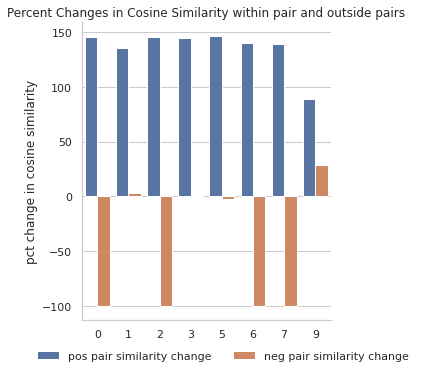

Average pair similarity change pct: 135.332
Average non-pair similarity change pct: -46.309944


In [146]:
import seaborn as sns
sns.set_theme(style='whitegrid')
cos_similarities_tp = pd.melt(cos_similarities, id_vars='pair_id', value_vars=['pos pair similarity change', 'neg pair similarity change'])

g = sns.catplot(data=cos_similarities_tp, kind='bar', x='pair_id', y='value', hue='variable', errorbar='sd')

g.set_axis_labels('', 'pct change in cosine similarity')
g.legend.set_title('')
sns.move_legend(g, loc='lower center', ncol=2)
plt.title('Percent Changes in Cosine Similarity within pair and outside pairs')
plt.show()

print('Average pair similarity change pct:', cos_similarities['pos pair similarity change'].mean())
print('Average non-pair similarity change pct:', cos_similarities['neg pair similarity change'].mean())


In [147]:
# Get all positive and negative keyword-image pairs for each keyword
pos_pairs = []
neg_pairs = []
for i in range(test_adj_matrix.shape[0]):
    kw_edges = test_adj_matrix[i]
    pos_matches = kw_edges.nonzero()[0]
    neg_matches = np.random.choice((kw_edges==0).nonzero()[0], len(pos_matches))
    for j in range(len(pos_matches)):
        pos_pairs.append((i, pos_matches[j]))
        neg_pairs.append((i, neg_matches[j]))

# Get src, pos_dst, and neg_dst node IDs
node_embeds_dict = {'src': {'feat': torch.empty((len(pos_pairs), 512)), 'feat_pred': torch.empty((len(pos_pairs), 512))}, 
                    'pos_dst': {'feat': torch.empty((len(pos_pairs), 512)), 'feat_pred': torch.empty((len(pos_pairs), 512))}, 
                    'neg_dst': {'feat': torch.empty((len(neg_pairs), 512)), 'feat_pred': torch.empty((len(neg_pairs), 512))}}

for i in range(len(pos_pairs)):
    src_idx, pos_dst_idx = pos_pairs[i]
    _, neg_dst_idx = neg_pairs[i]
    for embed_type in ['feat', 'feat_pred']:
        node_embeds_dict['src'][embed_type][i] = test_eval_subgraph.ndata[embed_type][eval_test_keyword_node_ids[src_idx]]
        node_embeds_dict['pos_dst'][embed_type][i] = test_eval_subgraph.ndata[embed_type][eval_test_img_node_ids[pos_dst_idx]]
        node_embeds_dict['neg_dst'][embed_type][i] = test_eval_subgraph.ndata[embed_type][eval_test_img_node_ids[neg_dst_idx]]



In [148]:
# For 10 samples, get pct change in pairwise cosine similarity for true src-dst pairs and negative pairs

import pandas as pd
from sklearn import metrics

cos_similarities = pd.DataFrame()

pos_sim_CLIP = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat'].detach().cpu().numpy(), 
                                                  node_embeds_dict['pos_dst']['feat'].detach().cpu().numpy())
pos_sim_SAGE = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat_pred'].detach().cpu().numpy(), 
                                                  node_embeds_dict['pos_dst']['feat_pred'].detach().cpu().numpy())

neg_sim_CLIP = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat'].detach().cpu().numpy(), 
                                                  node_embeds_dict['neg_dst']['feat'].detach().cpu().numpy())
neg_sim_SAGE = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat_pred'].detach().cpu().numpy(), 
                                                  node_embeds_dict['neg_dst']['feat_pred'].detach().cpu().numpy())

for i in tqdm(range(pos_sim_CLIP.shape[0])):
    cos_similarities = pd.concat([cos_similarities, pd.DataFrame([{'pair_id': i,
                                                                   'src_dst_sim_CLIP': pos_sim_CLIP[i,i],
                                                                   'non_pair_sim_CLIP': pos_sim_SAGE[i,i],
                                                                   'src_dst_sim_SAGE': pos_sim_SAGE[i,i],
                                                                   'non_pair_sim_SAGE': neg_sim_SAGE[i,i]}])])
cos_similarities.reset_index(inplace=True, drop=True)
cos_similarities['pos pair similarity change'] = (cos_similarities['src_dst_sim_SAGE'] - cos_similarities['src_dst_sim_CLIP']) / cos_similarities['src_dst_sim_CLIP'] * 100
cos_similarities['neg pair similarity change'] = (cos_similarities['non_pair_sim_SAGE'] - cos_similarities['non_pair_sim_CLIP']) / cos_similarities['non_pair_sim_CLIP'] * 100
cos_similarities = cos_similarities[cos_similarities['neg pair similarity change']!=np.inf]
cos_similarities.dropna(inplace=True)

print('Median pair similarity change pct:', cos_similarities['pos pair similarity change'].median())
print('Median non-pair similarity change pct:', cos_similarities['neg pair similarity change'].median())

100%|██████████| 12078/12078 [00:06<00:00, 1817.46it/s]


Median pair similarity change pct: 144.45366
Median non-pair similarity change pct: -100.0


# **Deprecated Code**

### Attempt to Only take Top_K Edges Per Node 

This did not seem to significantly improve performance, but could be improved upon 

In [149]:
def predict_top_k(a, k):
    n = len(a)
    mask_array = np.zeros(n, dtype=int)
    index_arr = np.argpartition(a, -k)[-k:]

    mask_array[index_arr] = 1

    return mask_array

top_k = True
if top_k:
    # Step 9: Get true labels for each keyword from validation subgraph adjacency matrix
    # Adjacency matrix needs to be sub-setted such that rows correspond only to image nodes and columns correspond only to keyword nodes
    val_img_indices = (val_subgraph.ndata['ntype']==0).nonzero().cpu().reshape(1, -1)
    val_keyword_indices = (val_subgraph.ndata['ntype']==1).nonzero().cpu().reshape(-1, 1)

    val_adj_matrix = val_subgraph.adjacency_matrix().to_dense().numpy()
    val_adj_matrix = val_adj_matrix[val_keyword_indices, val_img_indices]

    # Step 10: Make predictions based on prediction threshold and get precision, recall, and accuracy 
    k_thresholds = np.linspace(2, 50, 25)
    sage_clip_metrics_k = pd.DataFrame()

    for k_threshold in tqdm(k_thresholds):
        k_threshold = int(k_threshold)
        val_sage_link_predictions = np.apply_along_axis(predict_top_k, 0, val_sage_link_scores, k_threshold)
        val_clip_link_predictions = np.apply_along_axis(predict_top_k, 0, val_clip_link_scores, k_threshold)

        results_dict_k = {'sage': {'tp': np.empty(len(val_sage_link_predictions)),
                                'fp': np.empty(len(val_sage_link_predictions)),
                                'fn': np.empty(len(val_sage_link_predictions)),
                                'actual_p': np.empty(len(val_sage_link_predictions)),
                                'precision': np.empty(len(val_sage_link_predictions)),
                                'recall': np.empty(len(val_sage_link_predictions))},
                        'clip': {'tp': np.empty(len(val_sage_link_predictions)),
                                'fp': np.empty(len(val_sage_link_predictions)),
                                'fn': np.empty(len(val_sage_link_predictions)),
                                'actual_p': np.empty(len(val_sage_link_predictions)),
                                'precision': np.empty(len(val_sage_link_predictions)),
                                'recall': np.empty(len(val_sage_link_predictions))}}

        weights = np.empty(len(val_sage_link_predictions))

        for i in range(len(val_sage_link_predictions)):
            sage_tp = np.sum(((val_sage_link_predictions[i]==1)&(val_adj_matrix[i]==1)))
            sage_fp = np.sum(((val_sage_link_predictions[i]==1)&(val_adj_matrix[i]==0)))
            sage_fn = np.sum(((val_sage_link_predictions[i]==0)&(val_adj_matrix[i]==1)))
            sage_p = np.sum(val_sage_link_predictions[i])
            
            clip_tp = np.sum(((val_clip_link_predictions[i]==1)&(val_adj_matrix[i]==1)))
            clip_fp = np.sum(((val_clip_link_predictions[i]==1)&(val_adj_matrix[i]==0)))
            clip_fn = np.sum(((val_clip_link_predictions[i]==0)&(val_adj_matrix[i]==1)))
            clip_p = np.sum(val_clip_link_predictions[i])

            true_p = np.sum(val_adj_matrix[i])
            
            results_dict_k['sage']['tp'][i] = sage_tp
            results_dict_k['sage']['fp'][i] = sage_fp
            results_dict_k['sage']['fn'][i] = sage_fn
            results_dict_k['sage']['actual_p'][i] = true_p
            results_dict_k['sage']['precision'][i] = sage_tp / sage_p if sage_p > 0 else 0
            results_dict_k['sage']['recall'][i] = sage_tp / true_p if true_p > 0 else 0

            results_dict_k['clip']['tp'][i] = clip_tp
            results_dict_k['clip']['fp'][i] = clip_fp
            results_dict_k['clip']['fn'][i] = clip_fn
            results_dict_k['clip']['actual_p'][i] = true_p
            results_dict_k['clip']['precision'][i] = clip_tp / clip_p if clip_p > 0 else 0
            results_dict_k['clip']['recall'][i] = clip_tp / true_p if true_p > 0 else 0

            weights[i] = true_p

        weights /= np.sum(weights)

        for method in results_dict_k.keys():
            row = {'threshold': k_threshold, 'method': method}
            for metric in results_dict_k[method]:
                if metric == 'precision' or metric == 'recall':
                    row[f'{metric}_micro'] = np.mean(results_dict_k[method][metric]*weights)
                    row[f'{metric}_macro'] = np.mean(results_dict_k[method][metric])
                else:
                    row[metric] = np.mean(results_dict_k[method][metric])
            sage_clip_metrics_k = pd.concat([sage_clip_metrics_k, pd.DataFrame([row])], ignore_index=True)

    sage_metrics_k = sage_clip_metrics_k[(sage_clip_metrics_k['method']=='sage')]
    clip_metrics_k = sage_clip_metrics_k[(sage_clip_metrics_k['method']=='clip')]

print('Best SAGE metrics: ')
print('Precision, Recall at Max Recall:\n', sage_metrics_k[sage_metrics_k['recall_macro']==sage_metrics_k['recall_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])
print('Precision, Recall at Max Precision:\n', sage_metrics_k[sage_metrics_k['precision_macro']==sage_metrics_k['precision_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])

print('Best CLIP metrics: ')
print('Precision, Recall at Max Recall:\n', clip_metrics_k[clip_metrics_k['recall_macro']==clip_metrics_k['recall_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])
print('Precision, Recall at Max Precision:\n', clip_metrics_k[clip_metrics_k['precision_macro']==clip_metrics_k['precision_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])

100%|██████████| 25/25 [00:45<00:00,  1.81s/it]

Best SAGE metrics: 
Precision, Recall at Max Recall:
 threshold          50.000000
precision_macro     0.000449
recall_macro        0.023681
Name: 48, dtype: float64
Precision, Recall at Max Precision:
 threshold          28.000000
precision_macro     0.000602
recall_macro        0.011747
Name: 26, dtype: float64
Best CLIP metrics: 
Precision, Recall at Max Recall:
 threshold          50.000000
precision_macro     0.007283
recall_macro        0.250867
Name: 49, dtype: float64
Precision, Recall at Max Precision:
 threshold          4.000000
precision_macro    0.009695
recall_macro       0.037378
Name: 3, dtype: float64
